In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from lmfit import Model, Parameters
from lmfit.models import GaussianModel, SkewedGaussianModel
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools
from source.util import scatter_tools

In [2]:
directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim22_simple_optical_v1\20240303_Dark_Data_Auto\VNA_Sweeps"
filename = "S21_Segmented_BTEMP0240_mK_POW0.0_dB_ATT46.0_dB_1.fits"
file_path = os.path.join(directory, filename)

In [3]:
fits_vna_sweep = FitsFileLoadService.load_fits_vna_sweep_file(file_path=file_path)
frequency_array = fits_vna_sweep.data.frequency_array
s21_complex = fits_vna_sweep.data.get_iq_array()

number_of_tones = fits_vna_sweep.header.number_of_tones
print(f"Number of KID tones: {number_of_tones}")
fits_vna_sweep.header.print_attenuation_values()

# Split data into sub arrays corresponding to each kid:
frequency_array = np.split(frequency_array, number_of_tones)
s21_magnitude = np.abs(np.split(s21_complex, number_of_tones))

f0_array = []
qr_array = []
qc_array = []
qi_array = []

Number of KID tones: 15
Data file attenuation values:
Room temperature attenuation = 20.0
Variable Room temperature attenuation = 46.0dB
Cold attenuation = 20.0dB
Ultra-cold attenuation = 10.0dB
Output attenuation = 0.0dB
Total Amplifier Gain = 0dB


In [31]:
is_idc = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype="int")

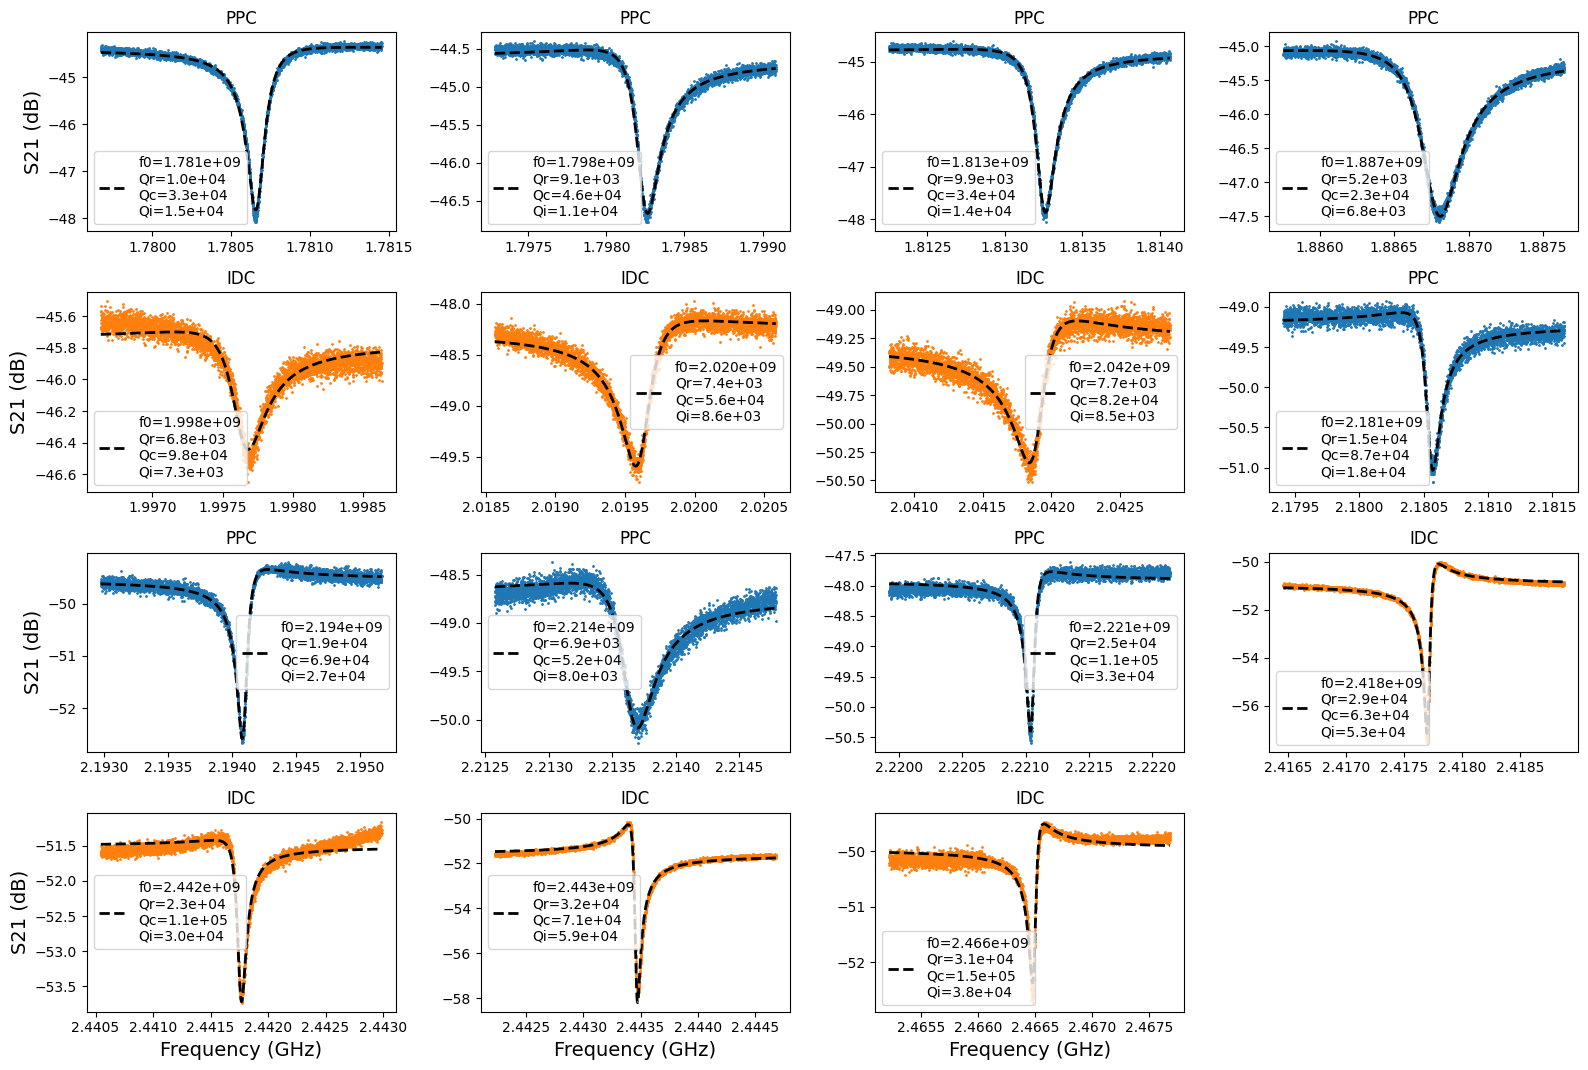

In [5]:
cmap = plt.get_cmap("tab10")

n_plots = number_of_tones
n_columns = 4
n_rows = math.ceil(n_plots / n_columns)

while n_rows == 1:
    n_columns -= 1
    n_rows = math.ceil(n_plots / n_columns)

row = 0
column = 0
figure, axes = plt.subplots(n_rows, n_columns, figsize=(16, n_rows * 3))

for count, kid_s21 in enumerate(s21_magnitude):

    color = cmap(0)
    label = "PPC"
    if is_idc[count] == 1:
        color=cmap(1)
        label="IDC"

    axes[row][column].plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(kid_s21),
        linestyle="none",
        marker="o",
        color=color,
        markersize="1",
    )
    fit_result_dict = lekid_analysis_tools.fit_skewed_lorentzian(
        frequency_array=frequency_array[count],
        data_array=kid_s21,
        qc_guess=1e5,
        qi_guess=1e5,
        f0_guess=None,
        fit_fraction=0.9,
        normalise=False,
        plot_db=True,
        plot_title=f"Skewed (Pete fitter) fit: KID {count}",
        plot_graph=False,
    )
    s21_fit = lekid_analysis_tools.skewed_lorentzian(
        frequency_array=frequency_array[count],
        f0=fit_result_dict["f0"][0],
        qi=fit_result_dict["qi"][0],
        qc_real=fit_result_dict["qc_real"][0],
        qc_imag=fit_result_dict["qc_imag"][0],
        amp=fit_result_dict["amp"][0],
    )
    axes[row][column].plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(s21_fit),
        linewidth=2,
        linestyle="--",
        color="k",
        label=f"f0={fit_result_dict['f0'][0]:.3e}\nQr={fit_result_dict['qr'][0]:.1e}\nQc={fit_result_dict['qc'][0]:.1e}\nQi={fit_result_dict['qi'][0]:.1e}"
    )
    axes[row][column].legend()
    axes[row][column].set_title(label)

    # Store f0 and quality factor data.
    f0_array.append(fit_result_dict["f0"][0])
    qr_array.append(fit_result_dict["qr"][0])
    qc_array.append(fit_result_dict["qc"][0])
    qi_array.append(fit_result_dict["qi"][0])


    if fit_result_dict["qi"][0] > 1e6:
        qi = fit_result_dict["qi"][0]
        print(f"KID{count}: Qi = {qi:.2E}")

    if column == 0:
        axes[row][column].set_ylabel("S21 (dB)", fontsize=14)

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)", fontsize=14)
    column += 1
    if column == n_columns:
        column = 0
        row += 1

# Remove extra subplots:
remaining_subplots = (n_columns * n_rows) - n_plots
if remaining_subplots > 0:
    for remaining_column in range(remaining_subplots):
        axes[row][column + remaining_column].remove()

plt.tight_layout(rect=(0, 0.1, 1, 1))
plt.show()
        

In [6]:
f0_array = np.array(f0_array)
qr_array = np.array(qr_array)
qc_array = np.array(qc_array)
qi_array = np.array(qi_array)

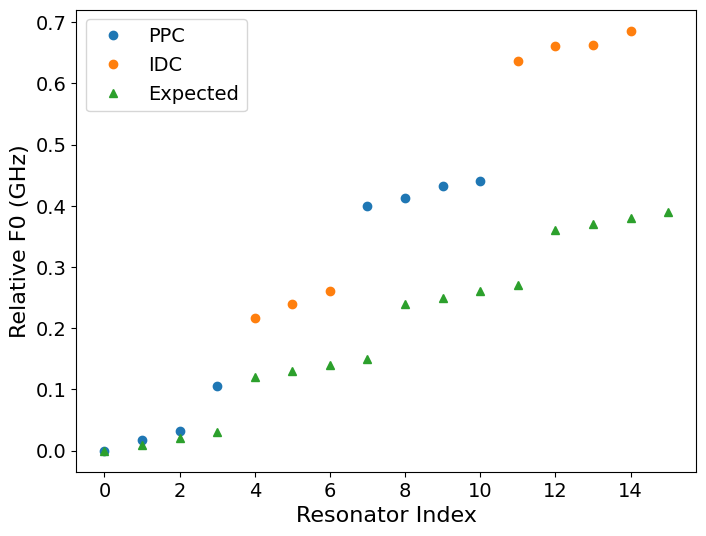

In [36]:
ppc_f0_array = np.array([2.01, 2.02, 2.03, 2.04, 2.25, 2.26, 2.27, 2.28]) * 1e9
idc_f0_array = np.array([2.13, 2.14, 2.15, 2.16, 2.37, 2.38, 2.39, 2.40]) * 1e9
expected_f0_array = np.sort(np.append(ppc_f0_array, idc_f0_array).flatten())

ppc_index = np.where(is_idc == 0)[0]
idc_index = np.where(is_idc)[0]

plt.figure(figsize=(8, 6))
plt.plot(ppc_index, (f0_array[ppc_index] - f0_array[0])*1e-9, linestyle="none", marker="o", label="PPC")
plt.plot(idc_index, (f0_array[idc_index] - f0_array[0])*1e-9, linestyle="none", marker="o", label="IDC")
plt.plot((expected_f0_array - expected_f0_array[0]) * 1e-9, marker="^", linestyle="none", color=cmap(2), label="Expected")
plt.ylabel("Relative F0 (GHz)", fontsize=16)
plt.xlabel("Resonator Index", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

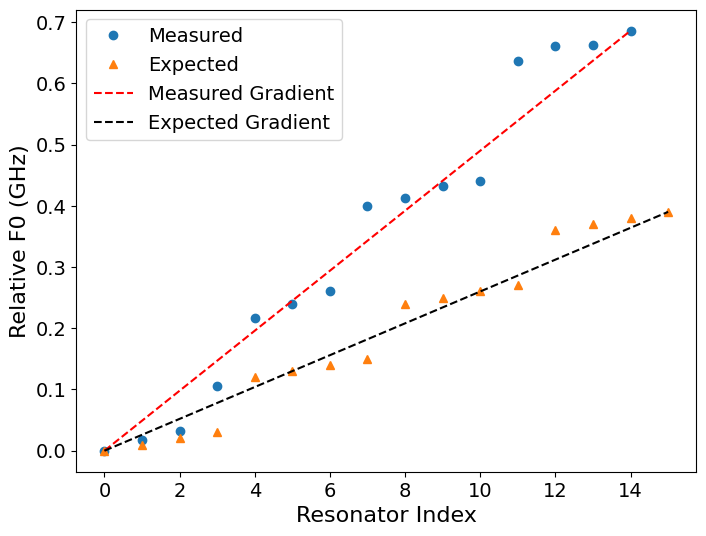

In [43]:
measured_gradient = (f0_array[-1] - f0_array[0])/16
expected_gradient = (expected_f0_array[-1] - expected_f0_array[0])/16

plt.figure(figsize=(8, 6))
plt.plot((f0_array - f0_array[0])*1e-9, linestyle="none", marker="o", label="Measured")
plt.plot((expected_f0_array - expected_f0_array[0]) * 1e-9, marker="^", linestyle="none", label="Expected")
plt.plot([0, 14], np.array([0, f0_array[-1] - f0_array[0]]) * 1e-9, color="r", label="Measured Gradient", linestyle="--")
plt.plot([0, 15], np.array([0, expected_f0_array[-1] - expected_f0_array[0]]) * 1e-9, color="k", label="Expected Gradient", linestyle="--")
plt.ylabel("Relative F0 (GHz)", fontsize=16)
plt.xlabel("Resonator Index", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

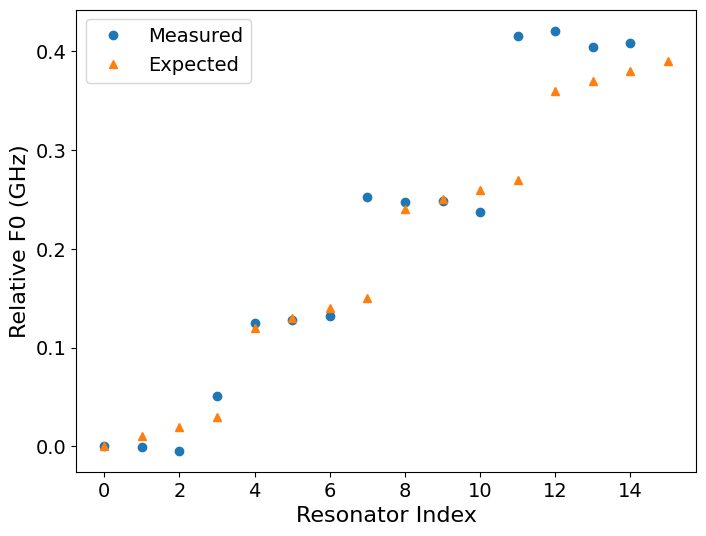

In [75]:
measured_gradient = (f0_array[-1] - f0_array[0])/16
expected_gradient = (expected_f0_array[-1] - expected_f0_array[0])/16
gradient_difference = measured_gradient - expected_gradient

measured_indices = np.array([0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

relative_scaled_f0_array = ((f0_array - (gradient_difference * measured_indices)) - f0_array[0])

plt.figure(figsize=(8, 6))
plt.plot(relative_scaled_f0_array * 1e-9, linestyle="none", marker="o", label="Measured")
plt.plot((expected_f0_array - expected_f0_array[0]) * 1e-9, marker="^", linestyle="none", label="Expected")
plt.ylabel("Relative F0 (GHz)", fontsize=16)
plt.xlabel("Resonator Index", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:

plt.figure(figsize=(8, 1))
plt.plot(relative_scaled_f0_array * 1e-9, np.zeros_like(expected_f0_array), linestyle="none", marker="o", color="k", label="Expected", markersize=6, fillstyle="none")
plt.plot((f0_array - f0_array[0]) * 1e-9,  np.zeros_like(f0_array), linestyle="none", marker="o", color="b", label="Measured", markersize=4)
plt.xlabel("Relative F0 (GHz)")
plt.ylabel(None)
plt.yticks([])
plt.show()